### Imports

In [ ]:
import sys
import scipy.io
import numpy as np
import mne
import matplotlib.pyplot as plt
from src.data_loader import SubjectData, load_subject, load_all_subjects

Import pointprocess module

In [2]:
PATH_TO_LIB = "pointprocess/build/" # "build/src/" 
# In my case the generated .so is build/src/pointprocess.cpython-310-darwin.so

sys.path.append(PATH_TO_LIB)

# Now we can import the Python byndings from the pointprocess library
from pointprocess import (
    compute_single_regression,
    compute_full_regression,
    compute_spectral_analysis,
    Distributions,
    Result,
    RegressionResult,
    get_ks_coords
)

### Load Subject Data

In [3]:
# Subject i01 - EMO data
subject_i01_emo = load_subject('i01', 'EMO')

rr_phase0 = subject_i01_emo.get_rr_data(phase_index=0)

### Plot RR Intervals

/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_60368/1915211578.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


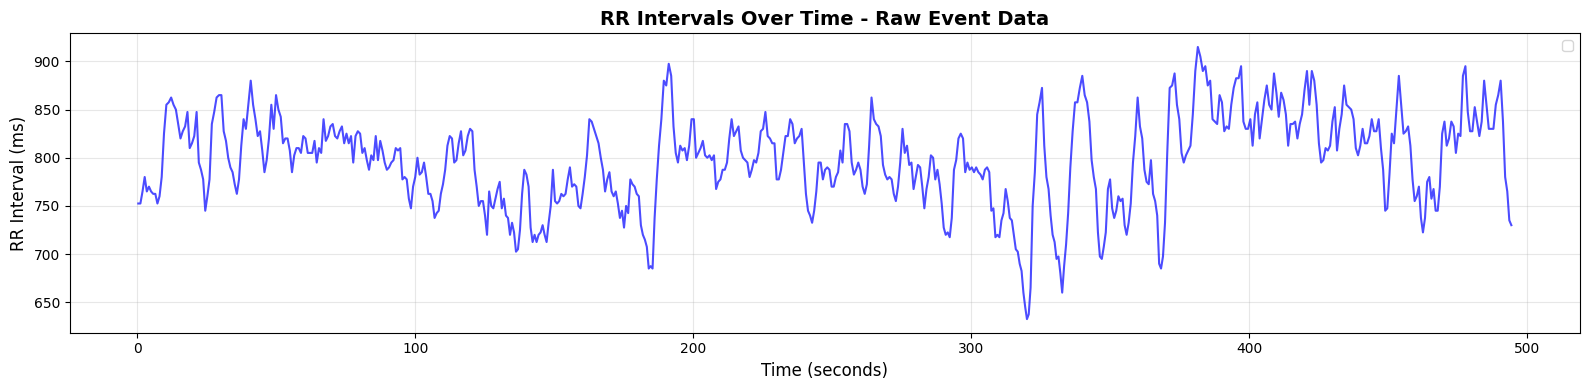

In [4]:
# Get RR intervals and timestamps
rr_intervals = subject_i01_emo.get_rr_data(phase_index=1).flatten()  # RR intervals in seconds
rr_times = subject_i01_emo.get_timestamps_rr(phase_index=1).flatten()  # Time of each R-peak

# Convert to milliseconds for easier visualization
rr_ms = rr_intervals * 1000

# Use regular figure/plot (no subplot)
plt.figure(figsize=(16, 4))

# Plot RR intervals over time
plt.plot(rr_times, rr_ms, linewidth=1.5, color='blue', alpha=0.7)

# Labels and formatting
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('RR Interval (ms)', fontsize=12)
plt.title('RR Intervals Over Time - Raw Event Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
subject_i01_emo.get_all_video_info()

[{'time_start': np.uint8(0), 'time_end': np.uint8(125), 'type': 'POS'},
 {'time_start': np.float64(184.97),
  'time_end': np.float64(309.97),
  'type': 'NEUT'},
 {'time_start': np.float64(369.972),
  'time_end': np.float64(494.972),
  'type': 'NEG'}]

VIDEO SEGMENTS - Subject i01 EMO:

Total video segments: 3

Video 1:
  Type:     POS
  Start:    0s
  End:      125s
  Duration: 125s

Video 2:
  Type:     NEUT
  Start:    184s
  End:      309s
  Duration: 125s

Video 3:
  Type:     NEG
  Start:    369s
  End:      494s
  Duration: 125s



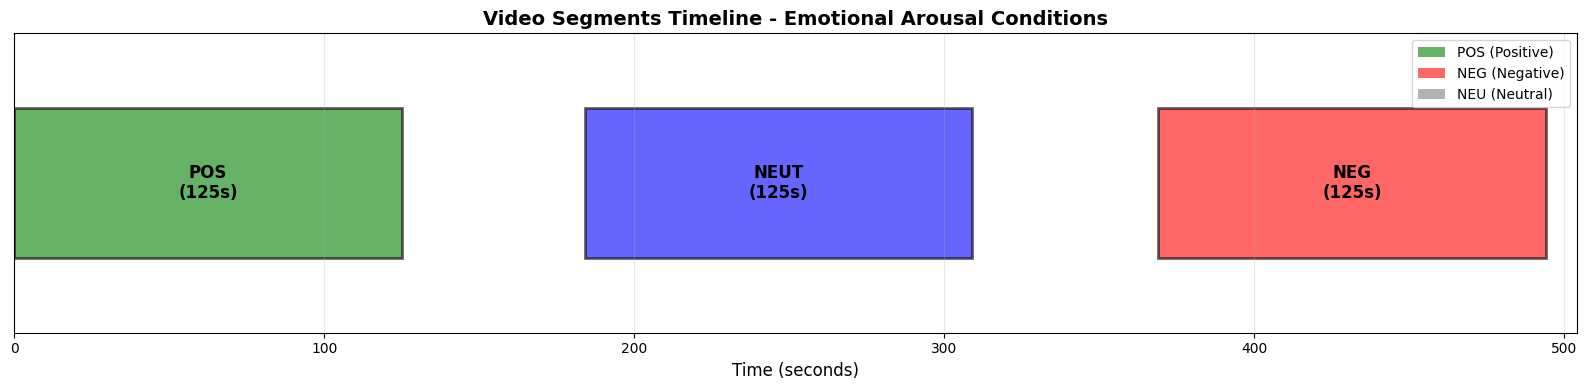

SUMMARY:
Total video duration: 375s
Positive segments: 1
Negative segments: 1
Neutral segments:  0


In [15]:
# Extract and display all video segments
print(f"{'='*70}")
print("VIDEO SEGMENTS - Subject i01 EMO:")
print(f"{'='*70}\n")

num_videos = subject_i01_emo.videos.shape[1]
print(f"Total video segments: {num_videos}\n")

video_segments = []
for i in range(num_videos):
    video = subject_i01_emo.videos[0, i]
    
    time_start = int(video['time_start'][0, 0][0, 0])
    time_end = int(video['time_end'][0, 0][0, 0])
    video_type = str(video['type'][0, 0][0])
    
    duration = time_end - time_start
    
    video_segments.append({
        'index': i,
        'type': video_type,
        'start': time_start,
        'end': time_end,
        'duration': duration
    })
    
    print(f"Video {i+1}:")
    print(f"  Type:     {video_type}")
    print(f"  Start:    {time_start}s")
    print(f"  End:      {time_end}s")
    print(f"  Duration: {duration}s")
    print()

# Visualize video timeline
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

colors = {'POS': 'green', 'NEG': 'red', 'NEU': 'gray'}
for seg in video_segments:
    color = colors.get(seg['type'], 'blue')
    ax.barh(0, seg['duration'], left=seg['start'], height=0.5, 
            color=color, alpha=0.6, edgecolor='black', linewidth=2)
    
    # Add label in the middle of each segment
    mid_point = seg['start'] + seg['duration'] / 2
    ax.text(mid_point, 0, f"{seg['type']}\n({seg['duration']}s)", 
            ha='center', va='center', fontsize=12, fontweight='bold')

ax.set_xlim(0, max([s['end'] for s in video_segments]) + 10)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_title('Video Segments Timeline - Emotional Arousal Conditions', fontsize=14, fontweight='bold')
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.6, label='POS (Positive)'),
                   Patch(facecolor='red', alpha=0.6, label='NEG (Negative)'),
                   Patch(facecolor='gray', alpha=0.6, label='NEU (Neutral)')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"{'='*70}")
print("SUMMARY:")
print(f"{'='*70}")
total_duration = sum([s['duration'] for s in video_segments])
print(f"Total video duration: {total_duration}s")
print(f"Positive segments: {sum([1 for s in video_segments if s['type'] == 'POS'])}")
print(f"Negative segments: {sum([1 for s in video_segments if s['type'] == 'NEG'])}")
print(f"Neutral segments:  {sum([1 for s in video_segments if s['type'] == 'NEU'])}")
print(f"{'='*70}")

### Inverse Guassian Regression

In [6]:
### Point Process Analysis - Compute HF Power Over Time# Fit Inverse Gaussian distribution to RR by moving a 60.0 seconds windows and shifting it by 0.005 s at each step.
# The mean of the ditribution will bi given by a 9th order AR model
result = compute_full_regression(
    events=rr_times,
    window_length=60.0,
    delta=0.005,
    ar_order=9,
    has_theta0=True,
    right_censoring=True,
    alpha = 0.02,
    distribution=Distributions.InverseGaussian,
    max_iter = 1000
)

# Compute spectral info
result.compute_hrv_indices()

# Convert result to dictionary...
d = result.to_dict()

Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l


In [7]:
# Check what keys are available in the result dictionary
print("Available keys in result dictionary:")
for key in d.keys():
    print(f"  - {key}: {type(d[key])}, shape: {d[key].shape if hasattr(d[key], 'shape') else 'N/A'}")

Available keys in result dictionary:
  - Likelihood: <class 'numpy.ndarray'>, shape: (86793, 1)
  - Mu: <class 'numpy.ndarray'>, shape: (86793, 1)
  - Time: <class 'numpy.ndarray'>, shape: (86793, 1)
  - cdf_is_one: <class 'numpy.ndarray'>, shape: (86793, 1)
  - converged: <class 'numpy.ndarray'>, shape: (86793, 1)
  - event_happened: <class 'numpy.ndarray'>, shape: (86793, 1)
  - lambda: <class 'numpy.ndarray'>, shape: (86793, 1)
  - max_grad: <class 'numpy.ndarray'>, shape: (86793, 1)
  - mean_interval: <class 'numpy.ndarray'>, shape: (86793, 1)
  - n_iter: <class 'numpy.ndarray'>, shape: (86793, 1)
  - powHF: <class 'numpy.ndarray'>, shape: (86793, 1)
  - powLF: <class 'numpy.ndarray'>, shape: (86793, 1)
  - powVLF: <class 'numpy.ndarray'>, shape: (86793, 1)
  - sigma: <class 'numpy.ndarray'>, shape: (86793, 1)
  - theta0: <class 'numpy.ndarray'>, shape: (86793, 1)
  - thetap: <class 'numpy.ndarray'>, shape: (86793, 9)


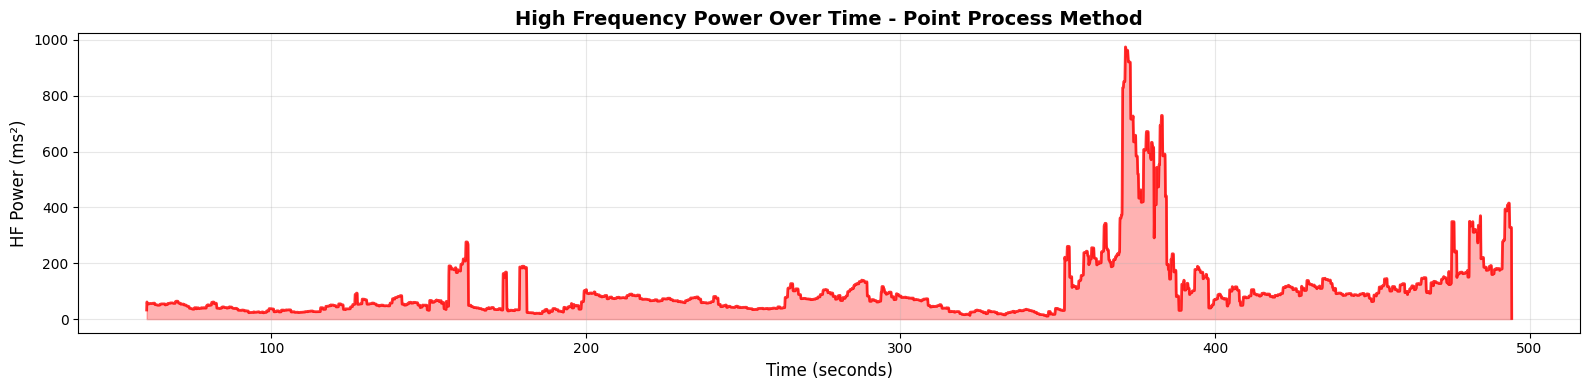

Mean HF Power:  100.98 ms²
Min HF Power:   2.31 ms²
Max HF Power:   974.74 ms²


In [8]:
# Extract HF power and time vector from results
hf_power = d["powHF"].flatten()  # High frequency power (0.15-0.4 Hz)
time_vector = d["Time"].flatten()  # Time points where HF power was estimated

# Create figure
plt.figure(figsize=(16, 4))

# HF Power over time
plt.plot(time_vector, hf_power, linewidth=2, color='red', alpha=0.8)
plt.fill_between(time_vector, hf_power, alpha=0.3, color='red')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('HF Power (ms²)', fontsize=12)
plt.title('High Frequency Power Over Time - Point Process Method', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean HF Power:  {np.mean(hf_power):.2f} ms²")
print(f"Min HF Power:   {np.min(hf_power):.2f} ms²")
print(f"Max HF Power:   {np.max(hf_power):.2f} ms²")

### Find Max and Min HF Power Moments

HF POWER EXTREMA:

MAXIMUM HF Power:
  Index:     62230
  Time:      371.53 seconds
  HF Power:  974.74 ms²

MINIMUM HF Power:
  Index:     86792
  Time:      494.34 seconds
  HF Power:  2.31 ms²


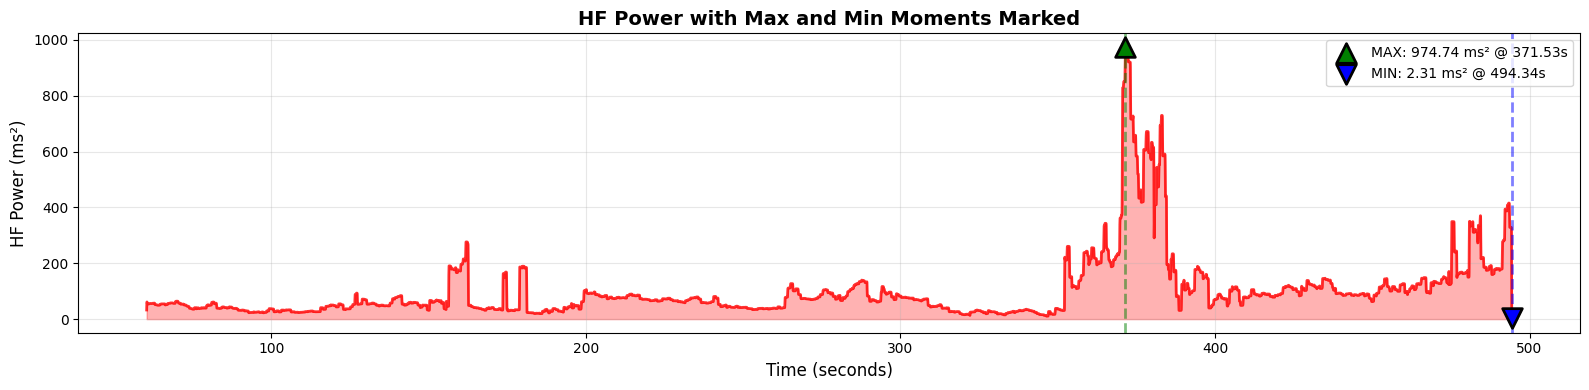

In [9]:
# Find indices of max and min HF power
idx_max_hf = np.argmax(hf_power)
idx_min_hf = np.argmin(hf_power)

# Get the corresponding times
time_max_hf = time_vector[idx_max_hf]
time_min_hf = time_vector[idx_min_hf]

# Get the HF power values
power_max_hf = hf_power[idx_max_hf]
power_min_hf = hf_power[idx_min_hf]

print(f"{'='*70}")
print("HF POWER EXTREMA:")
print(f"{'='*70}")
print(f"\nMAXIMUM HF Power:")
print(f"  Index:     {idx_max_hf}")
print(f"  Time:      {time_max_hf:.2f} seconds")
print(f"  HF Power:  {power_max_hf:.2f} ms²")

print(f"\nMINIMUM HF Power:")
print(f"  Index:     {idx_min_hf}")
print(f"  Time:      {time_min_hf:.2f} seconds")
print(f"  HF Power:  {power_min_hf:.2f} ms²")
print(f"{'='*70}")

# Visualize these moments on the HF power plot
plt.figure(figsize=(16, 4))
plt.plot(time_vector, hf_power, linewidth=2, color='red', alpha=0.8)
plt.fill_between(time_vector, hf_power, alpha=0.3, color='red')

# Mark max and min points
plt.scatter([time_max_hf], [power_max_hf], color='green', s=200, zorder=5, 
            label=f'MAX: {power_max_hf:.2f} ms² @ {time_max_hf:.2f}s', marker='^', edgecolors='black', linewidths=2)
plt.scatter([time_min_hf], [power_min_hf], color='blue', s=200, zorder=5, 
            label=f'MIN: {power_min_hf:.2f} ms² @ {time_min_hf:.2f}s', marker='v', edgecolors='black', linewidths=2)

# Add vertical lines at these moments
plt.axvline(x=time_max_hf, color='green', linestyle='--', alpha=0.5, linewidth=2)
plt.axvline(x=time_min_hf, color='blue', linestyle='--', alpha=0.5, linewidth=2)

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('HF Power (ms²)', fontsize=12)
plt.title('HF Power with Max and Min Moments Marked', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### EEG Topoplots at Max and Min HF Power Moments

In [13]:
# Load EEG data
eeg_raw = subject_i01_emo.get_eeg_data(phase_index=0)

# Get EEG sampling rate and convert times to samples
sfreq = eeg_raw.info['sfreq']

# Convert time points to sample indices
sample_max_hf = int(time_max_hf * sfreq)
sample_min_hf = int(time_min_hf * sfreq)

# Extract EEG data at these time points (±0.1s window average for stability)
window_samples = int(0.1 * sfreq)  # 0.1 second window

# Get data windows around the max and min moments
data_max = eeg_raw.get_data(start=sample_max_hf - window_samples, 
                             stop=sample_max_hf + window_samples)
data_min = eeg_raw.get_data(start=sample_min_hf - window_samples, 
                             stop=sample_min_hf + window_samples)

# Average over the time window
eeg_at_max = data_max.mean(axis=1)  # Average across time for each channel
eeg_at_min = data_min.mean(axis=1)

/Users/zeyad/Documents/projects/brain-heart-microstates-of-emotional-arousal/data_loader.py:267: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, verbose=False)
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_60368/3319121429.py:21: RuntimeWarning: Mean of empty slice.
  eeg_at_max = data_max.mean(axis=1)  # Average across time for each channel
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_60368/3319121429.py:22: RuntimeWarning: Mean of empty slice.
  eeg_at_min = data_min.mean(axis=1)


/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_60368/3312281957.py:5: RuntimeWarning: Estimated head radius (100.0 cm) is above the 99th percentile for adult head size.
  im1, cn1 = mne.viz.plot_topomap(
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_60368/3312281957.py:21: RuntimeWarning: Estimated head radius (100.0 cm) is above the 99th percentile for adult head size.
  im2, cn2 = mne.viz.plot_topomap(


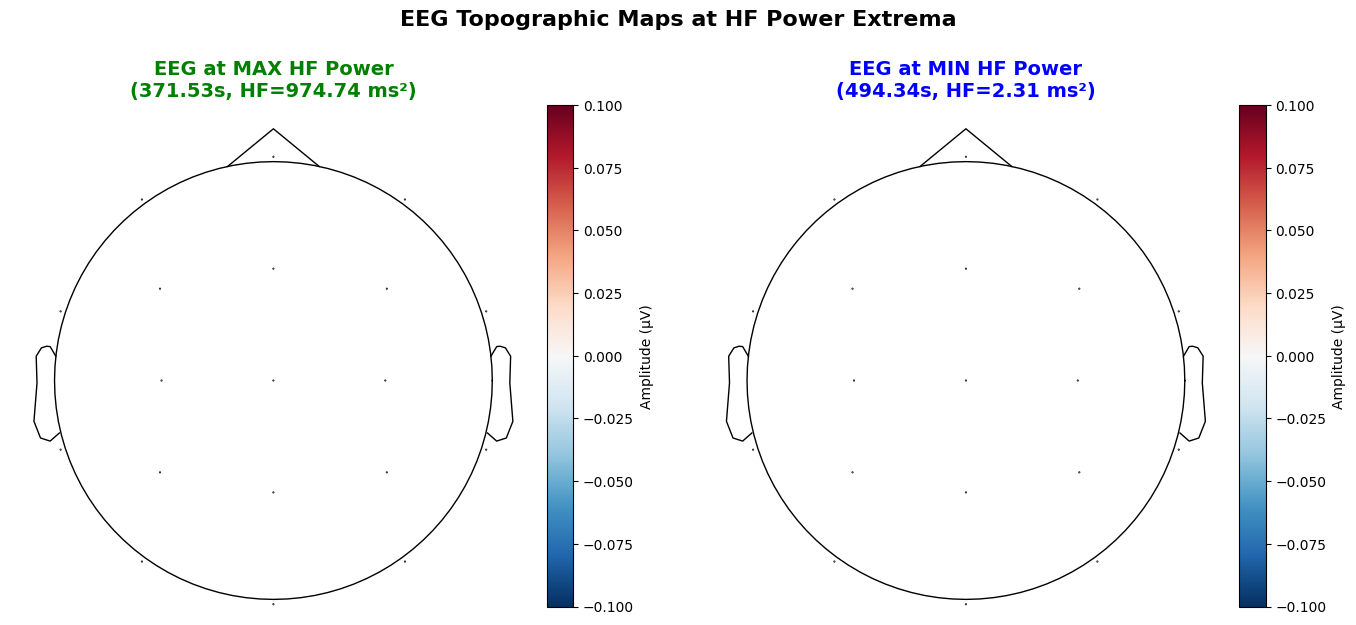

In [14]:
# Create better-sized topoplots with controlled extrapolation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: EEG topoplot at MAX HF power
im1, cn1 = mne.viz.plot_topomap(
    eeg_at_max, eeg_raw.info, 
    axes=axes[0], 
    show=False, 
    cmap='RdBu_r', 
    contours=6, 
    sensors=True,
    sphere='auto',           # Auto-fit sphere to electrode positions
    extrapolate='head',      # Only extrapolate within head - prevents over-extension
    outlines='head',         # Draw head outline
    image_interp='cubic'     # Smoother interpolation
)
axes[0].set_title(f'EEG at MAX HF Power\n({time_max_hf:.2f}s, HF={power_max_hf:.2f} ms²)', 
                  fontsize=14, fontweight='bold', color='green')

# Plot 2: EEG topoplot at MIN HF power
im2, cn2 = mne.viz.plot_topomap(
    eeg_at_min, eeg_raw.info, 
    axes=axes[1], 
    show=False, 
    cmap='RdBu_r', 
    contours=6, 
    sensors=True,
    sphere='auto',
    extrapolate='head',
    outlines='head',
    image_interp='cubic'
)
axes[1].set_title(f'EEG at MIN HF Power\n({time_min_hf:.2f}s, HF={power_min_hf:.2f} ms²)', 
                  fontsize=14, fontweight='bold', color='blue')

# Add colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable
for ax, im in zip(axes, [im1, im2]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='Amplitude (µV)')

plt.suptitle('EEG Topographic Maps at HF Power Extrema', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
